### Monitoring Bulk Reindex from DataDog

 - Live DataDog NoteBook : https://app.datadoghq.com/notebook/275266/index-us-west
 - [Archived NoteBook](monitoring/US-WEST-INDEX-CSV/Index%20US-WEST%20_%20Datadog%20(2020-09-15%204_15_48%20PM).html)
 
Basically what we see is:

 - during the scroll time, MongoDB is the limiting factor
     - the `index` computation is not able to fetch data from MongoDB fast enough and as a result
         - the bulk indexing is not lagging
         - nuxeo CPU is low
         - ES throughput and CPU is low
 - when the scroll is over, it releases some MongoDB resources
     - the `index` computation start getting faster
         - the bulk indexing starts getting some lag
         - Nuxeo CPU is higher because worker are busing generating the JSON indexing requests
         - ES CPU is much higher because the bulkIndex computation created more pressure
     - ES CPU and IO becomes the bottleneck
 
 During the first phase, we may be able to spread the MongoDB READ workload by allowing to read data from Secondary
 
     ?readPreference=nearest
 
### Custom Charts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



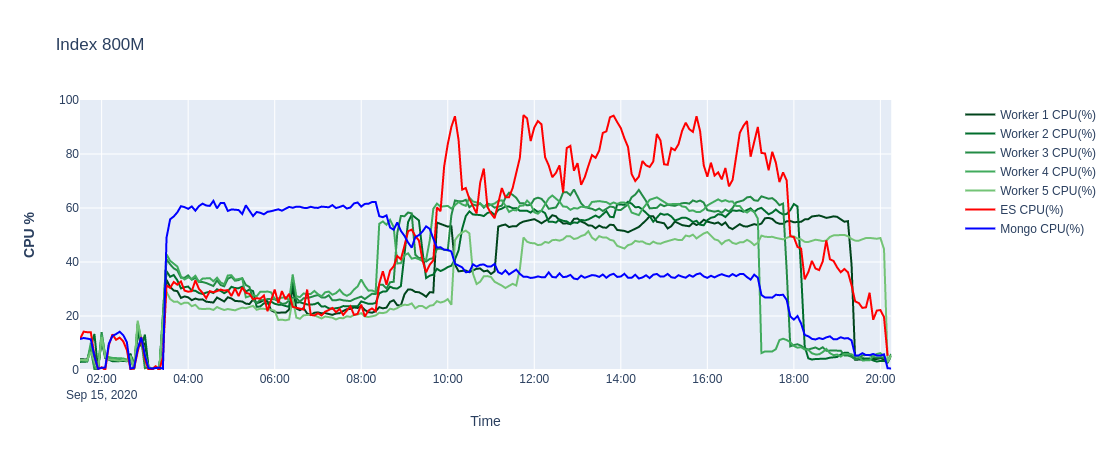

In [76]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

cpu = pd.read_csv("monitoring/US-WEST-INDEX-CSV/extract-2020-09-15T20_16_07.751Z-avg_system.cpu.idle{staging_bench-11} by {hostname}.csv")
escpu = pd.read_csv("monitoring/US-WEST-INDEX-CSV/extract-2020-09-15T20_22_27.921Z-max_aws.es.cpuutilization.maximum{staging_bench-11}.csv")
mongocpu = pd.read_csv("monitoring/US-WEST-INDEX-CSV/extract-2020-09-15T20_16_32.818Z-max_mongodb.atlas.system.cpu.norm.user{projectname_nxbench-bench11,replicasetname_atlas-880fxr-shard-0}.csv")

cpuLines=cpu.group.str.contains("worker")
workersCpu=cpu[cpuLines]
workersCpu['cpu'] = workersCpu.apply(lambda row: 100-row.value, axis = 1) 


colors = px.colors.sequential.Greens.copy()
workers = workersCpu.group.unique()

#fig = px.line(df_long, x='Date', y='value', color='variable')
#workerCpu['color'] = workerCpu.apply(lambda row: plasma[np.where(workers == row.group)[0][0]], axis = 1) 
#workerCpu

fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add Worker CPUs
i=0
for worker in workers:   
    if (worker.find("10-3-10-10")<0):
        i+=1
        workerCpu = workersCpu[workersCpu["group"]==worker]
        fig.add_trace(
            go.Scatter(x = workerCpu['time'], y = workerCpu['cpu'],name='Worker '+ str(i) + ' CPU(%)', line_color=colors.pop()),
            secondary_y=False,
        )

fig.add_trace(
    go.Scatter(x = escpu['time'], y = escpu['value'],name='ES CPU(%)', line_color='red'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = mongocpu['time'], y = mongocpu['value'],name='Mongo CPU(%)', line_color='blue'),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Index 800M"
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>CPU %</b>", secondary_y=False, range=[0,100])
#fig.update_yaxes(title_text="<b>Throughtput</b> doc/s", secondary_y=True)

fig.show()

